In [5]:
# %%
import os
import numpy as np
import pydicom
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [6]:
import shutil


# Load the CSV file with patient groups
data = pd.read_csv('/home/antriksh/Desktop/DAV PROJECT/mil_gaya_4_02_2025.csv')

# Display group distribution
print("Original group distribution:")
print(data["Group"].value_counts())

# Sample 50 patients from each group
pd_patients = data[data["Group"] == "PD"].sample(50, random_state=42)
swedd_patients = data[data["Group"] == "SWEDD"].sample(50, random_state=42)
control_patients = data[data["Group"] == "Control"].sample(50, random_state=42)

# Combine to create balanced dataset
balanced_data = pd.concat([pd_patients, swedd_patients, control_patients])
print("\nBalanced dataset distribution:")
print(balanced_data["Group"].value_counts())


Original group distribution:
Group
PD         1424
Control     213
SWEDD       137
Name: count, dtype: int64

Balanced dataset distribution:
Group
PD         50
SWEDD      50
Control    50
Name: count, dtype: int64


In [7]:

# Create a list of patient IDs to include
selected_patient_ids = balanced_data['Subject'].tolist()  # Assuming 'PatientID' is the column name

def load_dicom_series(root_folder, patient_ids):
    """
    Recursively loads DICOM files for specified patient IDs only.
    """
    patient_volumes = {}  # Dictionary to store volumes per patient

    for dirpath, _, filenames in os.walk(root_folder):  # Walk through all subdirectories
        dicom_files = sorted([f for f in filenames if f.endswith(".dcm")])  # Sort for correct order

        if dicom_files:  # If the folder contains DICOM files
            patient_id = dirpath.split("/")[-2]  # Extract patient ID from folder name
            
            # Only process patients in our selected list
            if patient_id in patient_ids:
                slices = [pydicom.dcmread(os.path.join(dirpath, f)).pixel_array for f in dicom_files]
                volume = np.stack(slices, axis=-1)  # Stack slices to form 3D volume
                patient_volumes[patient_id] = volume

    return patient_volumes

In [8]:

def preprocess_volume(volume, target_size=(64, 64, 64)):
    """
    Normalizes and resizes the 3D volume.
    """
    # Normalize (Scale values between 0 and 1)
    volume = volume.astype(np.float32) / np.max(volume)

    # Resize each 2D slice correctly
    # Remove the extra channel dimension if present
    if volume.ndim == 4 and volume.shape[-1] == 1:
        volume = np.squeeze(volume, axis=-1)

    resized_slices = [cv2.resize(slice, target_size[:2]) for slice in volume[..., 0]]
    resized_volume = np.stack(resized_slices, axis=-1)  # Stack resized slices

    return np.expand_dims(resized_volume, axis=-1)  # Add channel dimension


In [9]:

# Load only the selected patient volumes
print("\nLoading DICOM files for selected patients...")
root_folder = "PPMI"  # Adjust to your dataset's root directory
spect_volumes = load_dicom_series(root_folder, selected_patient_ids)

# Preprocess the volumes
print("\nPreprocessing volumes...")
preprocessed_volumes = {pid: preprocess_volume(vol) for pid, vol in spect_volumes.items()}

# Create feature arrays and labels
print("\nPreparing training data...")
X = []
y = []

# Ensure all volumes have the same shape
volume_shape = (64, 64, 64, 1)  # Target shape

# Create a mapping between patient ID and group
patient_group_mapping = dict(zip(balanced_data['Subject'], balanced_data['Group']))

# Define group to numeric label mapping
group_to_label = {
    'PD': 0,
    'SWEDD': 1,
    'Control': 2
}



Loading DICOM files for selected patients...

Preprocessing volumes...

Preparing training data...


In [10]:

for patient_id, vol in preprocessed_volumes.items():
    vol = np.squeeze(vol)  # Remove unnecessary singleton dimensions

    # Ensure the depth is correct
    num_slices = vol.shape[-1]
    if num_slices != 64:
        resized_slices = []
        for i in range(64):  # Always create exactly 64 slices
            idx = int(i * num_slices / 64)  # Sample indices proportionally
            resized_slices.append(cv2.resize(vol[:, :, idx], volume_shape[:2]))  
        vol = np.stack(resized_slices, axis=-1)  # Stack into depth

    vol = np.expand_dims(vol, axis=-1)  # Ensure (64, 64, 64, 1)
    X.append(vol)
    
    # Get the group for this patient
    group = patient_group_mapping.get(patient_id)
    if group is not None:
        y.append(group_to_label[group])
    else:
        print(f"Warning: Patient {patient_id} not found in dataset. Skipping.")


In [11]:

# Ensure X and y are populated with data
if len(X) == 0 or len(y) == 0:
	raise ValueError("X and y are empty. Ensure that data is loaded and preprocessed correctly before splitting.")

X = np.array(X)  # Convert list to numpy array
y = np.array(y)  # Convert labels to numpy array

# One-hot encode the labels
y_onehot = to_categorical(y, num_classes=3)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("y_onehot shape:", y_onehot.shape)

# Split data into training and validation sets
if len(X) > 0:
	X_train, X_val, y_train, y_val = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y)
	print("\nTraining split:", X_train.shape, y_train.shape)
	print("Validation split:", X_val.shape, y_val.shape)
else:
	print("No data available for splitting.")


ValueError: X and y are empty. Ensure that data is loaded and preprocessed correctly before splitting.

In [ ]:

# Model architecture for 3-class classification
model = Sequential([
    Conv3D(32, kernel_size=(3,3,3), activation='relu', input_shape=(64, 64, 64, 1)),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2)),

    Conv3D(64, kernel_size=(3,3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2)),

    Conv3D(128, kernel_size=(3,3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # Changed to 3 output neurons for 3 classes with softmax
])

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',  # Changed to categorical_crossentropy for multi-class
              metrics=['accuracy'])

# Print model summary
model.summary()


In [ ]:

# Train
print("\nTraining model...")
history = model.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=2, 
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    ]
)

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_val, y_val)
print(f"\nTest accuracy: {test_accuracy:.4f}")


NameError: name 'history' is not defined

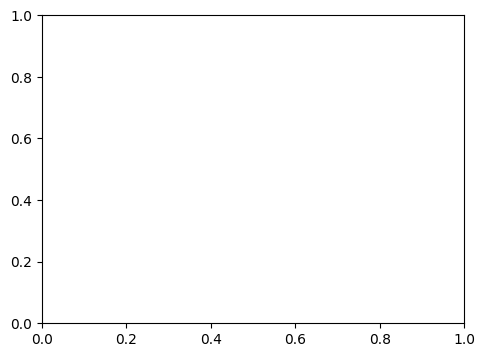

In [11]:

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [1]:
# %%
import os
import numpy as np
import pydicom
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load the CSV file with patient groups
data = pd.read_csv('/home/antriksh/Desktop/DAV PROJECT/maam_ne_daanta/datscan_4_22_2025.csv')

# Display group distribution
print("Original group distribution:")
print(data["Group"].value_counts())

# Check if we have enough patients in each group
pd_count = len(data[data["Group"] == "PD"])
swedd_count = len(data[data["Group"] == "SWEDD"])
control_count = len(data[data["Group"] == "Control"])

print(f"\nAvailable patients: PD={pd_count}, SWEDD={swedd_count}, Control={control_count}")

# Determine how many to sample from each group (up to 50)
n_pd = min(100, pd_count)
n_swedd = min(100, swedd_count)
n_control = min(100, control_count)

print(f"Sampling: PD={n_pd}, SWEDD={n_swedd}, Control={n_control}")

# Sample from each group
pd_patients = data[data["Group"] == "PD"].sample(n_pd, random_state=42)
swedd_patients = data[data["Group"] == "SWEDD"].sample(n_swedd, random_state=42)
control_patients = data[data["Group"] == "Control"].sample(n_control, random_state=42)

# Combine to create balanced dataset
balanced_data = pd.concat([pd_patients, swedd_patients, control_patients])
print("\nBalanced dataset distribution:")
print(balanced_data["Group"].value_counts())

# %%
# Print the first few rows to see column names
print("\nDataset columns:", data.columns.tolist())
print("\nFirst few rows of the balanced dataset:")
print(balanced_data.head())

# Determine which column contains the patient identifiers
# Adjust this based on your actual column name
id_column = 'Patient ID'  # Try different possibilities
if id_column not in balanced_data.columns:
    # Alternative column names to try
    possible_id_columns = ['PatientID', 'Patient_ID', 'ID', 'Subject', 'SubjectID']
    for col in possible_id_columns:
        if col in balanced_data.columns:
            id_column = col
            break
    else:
        # If none of the above work, use the first column
        id_column = balanced_data.columns[0]
        print(f"Warning: Using {id_column} as the patient identifier column")

print(f"\nUsing '{id_column}' as the patient identifier column")

# Create a list of patient IDs to include
selected_patient_ids = balanced_data[id_column].astype(str).tolist()
print(f"Selected {len(selected_patient_ids)} patient IDs")
print("Sample IDs:", selected_patient_ids[:5])

# %%
def explore_directory(root_folder, max_depth=3, current_depth=0):
    """
    Explore the directory structure to help diagnose issues
    """
    if current_depth > max_depth:
        return
    
    print("  " * current_depth + f"|- {os.path.basename(root_folder)}/")
    
    try:
        items = os.listdir(root_folder)
        for item in items[:5]:  # Limit to first 5 items to avoid clutter
            path = os.path.join(root_folder, item)
            if os.path.isdir(path):
                explore_directory(path, max_depth, current_depth + 1)
            elif item.endswith(".dcm"):
                print("  " * (current_depth + 1) + f"|- {item}")
        
        if len(items) > 5:
            print("  " * (current_depth + 1) + f"|- ... ({len(items) - 5} more items)")
    except Exception as e:
        print("  " * (current_depth + 1) + f"Error: {str(e)}")

# Explore the root directory structure
print("\nExploring directory structure:")
root_folder = "new_model_masti"  # Adjust to your dataset's root directory
explore_directory(root_folder)

# %%
def load_dicom_series(root_folder, patient_ids):
    """
    Recursively loads DICOM files for specified patient IDs only.
    Includes additional debugging information.
    """
    patient_volumes = {}  # Dictionary to store volumes per patient
    found_patients = set()
    searched_folders = 0

    print(f"\nSearching for {len(patient_ids)} patients in {root_folder}...")
    
    for dirpath, dirnames, filenames in os.walk(root_folder):  # Walk through all subdirectories
        searched_folders += 1
        if searched_folders % 100 == 0:
            print(f"Searched {searched_folders} folders, found {len(found_patients)} patients so far...")
        
        dicom_files = sorted([f for f in filenames if f.endswith(".dcm")])  # Sort for correct order

        if dicom_files:  # If the folder contains DICOM files
            # Extract patient ID from folder path - try different splitting methods
            path_parts = dirpath.split("/")
            folder_name = path_parts[-1] if path_parts[-1] else path_parts[-2]
            
            # Try different ways to extract patient ID
            patient_id_candidates = [
                dirpath.split("/")[-2],  # Original method
                folder_name,
                os.path.basename(os.path.dirname(dirpath)),
                "_".join(folder_name.split("_")[:2])  # Try to extract ID if format is like "ID_DATE"
            ]
            
            # Try all candidates
            matched = False
            for patient_id in patient_id_candidates:
                if patient_id in patient_ids:
                    matched = True
                    found_patients.add(patient_id)
                    
                    try:
                        slices = [pydicom.dcmread(os.path.join(dirpath, f)).pixel_array for f in dicom_files]
                        volume = np.stack(slices, axis=-1)  # Stack slices to form 3D volume
                        patient_volumes[patient_id] = volume
                        print(f"Loaded patient {patient_id} with volume shape {volume.shape}")
                        break
                    except Exception as e:
                        print(f"Error loading DICOM for patient {patient_id}: {str(e)}")
            
            # If we didn't match by exact ID, try substring matching
            if not matched:
                for pid in patient_ids:
                    # Check if the patient ID is contained within the folder name
                    for candidate in patient_id_candidates:
                        if pid in candidate or candidate in pid:
                            try:
                                print(f"Trying fuzzy match: '{pid}' with '{candidate}'")
                                slices = [pydicom.dcmread(os.path.join(dirpath, f)).pixel_array for f in dicom_files]
                                volume = np.stack(slices, axis=-1)
                                patient_volumes[pid] = volume
                                found_patients.add(pid)
                                print(f"Loaded patient {pid} with volume shape {volume.shape} (fuzzy match)")
                                break
                            except Exception as e:
                                print(f"Error loading DICOM with fuzzy match: {str(e)}")

    print(f"\nFound {len(found_patients)} out of {len(patient_ids)} patients")
    print(f"Missing patients: {set(patient_ids) - found_patients}")
    
    return patient_volumes

# %%
def preprocess_volume(volume, target_size=(64, 64, 64)):
    """
    Normalizes and resizes the 3D volume.
    """
    try:
        # Normalize (Scale values between 0 and 1)
        volume = volume.astype(np.float32) / np.max(volume) if np.max(volume) > 0 else volume.astype(np.float32)

        # Handle different dimension possibilities
        if volume.ndim == 4 and volume.shape[-1] == 1:
            volume = np.squeeze(volume, axis=-1)  # Remove extra channel dimension
        elif volume.ndim == 2:
            # Single slice - expand to 3D
            volume = np.expand_dims(volume, axis=-1)
        
        num_slices = volume.shape[-1] if volume.ndim >= 3 else 1
        
        # Handle 2D vs 3D volumes
        if volume.ndim < 3:
            print(f"Warning: Volume has unexpected shape {volume.shape}, expanding dimensions")
            return np.zeros(target_size + (1,))  # Return zero volume of correct shape
            
        # Resize each 2D slice
        resized_slices = []
        for i in range(min(num_slices, target_size[2])):
            slice_2d = volume[:, :, i] if i < num_slices else np.zeros(volume.shape[:2])
            resized_slices.append(cv2.resize(slice_2d, target_size[:2]))
        
        # If we don't have enough slices, pad with zeros
        while len(resized_slices) < target_size[2]:
            resized_slices.append(np.zeros(target_size[:2]))
            
        resized_volume = np.stack(resized_slices, axis=-1)  # Stack resized slices
        return np.expand_dims(resized_volume, axis=-1)  # Add channel dimension
        
    except Exception as e:
        print(f"Error in preprocessing: {str(e)}")
        print(f"Volume shape: {volume.shape}, dtype: {volume.dtype}")
        # Return a zero volume of the correct shape
        return np.zeros(target_size + (1,))

# %%
# Load only the selected patient volumes
print("\nLoading DICOM files for selected patients...")
root_folder = "PPMI"  # Adjust to your dataset's root directory
spect_volumes = load_dicom_series(root_folder, selected_patient_ids)

if not spect_volumes:
    print("\nNo volumes were loaded. Let's try a different approach.")
    # Try loading all volumes and then filter
    print("Loading a sample of volumes to identify patient ID format...")
    
    # Walk through directories to find DICOM files and identify pattern
    example_dicoms = []
    for dirpath, _, filenames in os.walk(root_folder):
        dicom_files = [f for f in filenames if f.endswith(".dcm")]
        if dicom_files:
            example_dicoms.append((dirpath, dicom_files[0]))
            if len(example_dicoms) >= 3:
                break
    
    # Try to extract patient ID from DICOM metadata
    for dirpath, filename in example_dicoms:
        try:
            dcm = pydicom.dcmread(os.path.join(dirpath, filename))
            print(f"\nExample DICOM file: {os.path.join(dirpath, filename)}")
            print("PatientID in DICOM:", dcm.PatientID if hasattr(dcm, 'PatientID') else "Not available")
            print("PatientName in DICOM:", dcm.PatientName if hasattr(dcm, 'PatientName') else "Not available")
            print("Directory structure:", dirpath)
        except Exception as e:
            print(f"Error reading DICOM: {str(e)}")

# %%
# Preprocess the volumes
print("\nPreprocessing volumes...")
preprocessed_volumes = {}

for pid, vol in spect_volumes.items():
    try:
        preprocessed_vol = preprocess_volume(vol)
        preprocessed_volumes[pid] = preprocessed_vol
        print(f"Preprocessed patient {pid}, output shape: {preprocessed_vol.shape}")
    except Exception as e:
        print(f"Error preprocessing volume for patient {pid}: {str(e)}")

# %%
# Create feature arrays and labels
print("\nPreparing training data...")
X = []
y = []

# Ensure all volumes have the same shape
volume_shape = (64, 64, 64, 1)  # Target shape

# Create a mapping between patient ID and group
patient_group_mapping = dict(zip(balanced_data[id_column].astype(str), balanced_data['Group']))

# Define group to numeric label mapping
group_to_label = {
    'PD': 0,
    'SWEDD': 1,
    'Control': 2
}

for patient_id, vol in preprocessed_volumes.items():
    try:
        # Get the group for this patient
        group = patient_group_mapping.get(patient_id)
        if group is not None:
            # Process the volume
            vol = np.squeeze(vol)  # Remove unnecessary singleton dimensions

            # Ensure the depth is correct
            num_slices = vol.shape[-1]
            if num_slices != 64:
                resized_slices = []
                for i in range(64):  # Always create exactly 64 slices
                    idx = min(int(i * num_slices / 64), num_slices - 1)  # Sample indices proportionally
                    resized_slices.append(cv2.resize(vol[:, :, idx], volume_shape[:2]))  
                vol = np.stack(resized_slices, axis=-1)  # Stack into depth

            vol = np.expand_dims(vol, axis=-1)  # Ensure (64, 64, 64, 1)
            X.append(vol)
            y.append(group_to_label[group])
            print(f"Added patient {patient_id}, group: {group}")
        else:
            print(f"Warning: Patient {patient_id} not found in dataset mapping. Skipping.")
    except Exception as e:
        print(f"Error processing patient {patient_id}: {str(e)}")

# Verify we have data
print(f"\nCollected data: {len(X)} samples with {len(y)} labels")

# Ensure X and y are populated with data
if len(X) == 0 or len(y) == 0:
    print("ERROR: X and y are empty. The following steps will be skipped.")
    print("Try checking the relationship between patient IDs in the CSV and folder structure.")
    # Don't raise an error, just proceed to show what would happen next
else:
    X = np.array(X)  # Convert list to numpy array
    y = np.array(y)  # Convert labels to numpy array

    # One-hot encode the labels
    y_onehot = to_categorical(y, num_classes=3)

    print("X shape:", X.shape)
    print("y shape:", y.shape)
    print("y_onehot shape:", y_onehot.shape)

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y)

    print("\nTraining split:", X_train.shape, y_train.shape)
    print("Validation split:", X_val.shape, y_val.shape)

# Improved model architecture for 3-class SPECT classification
# 3D CNN model for 3-class classification
model = Sequential([

    Conv3D(32, kernel_size=(3, 3, 3), activation='relu',input_shape=(64, 64, 64, 1), padding='same'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 2, 2)),

    Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 2, 2)),

    Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(3, activation='softmax')  # 3-class output
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Compile with better learning rate scheduling
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Print model summary
model.summary()

    # Train
print("\nTraining model...")
history = model.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=2, 
    validation_data=(X_val, y_val),
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    #     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    # ]
)

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_val, y_val)
print(f"\nTest accuracy: {test_accuracy:.4f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

2025-04-22 16:28:09.694667: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745319489.759469    5298 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745319489.776790    5298 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745319489.892477    5298 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745319489.892508    5298 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745319489.892511    5298 computation_placer.cc:177] computation placer alr

Original group distribution:
Group
PD         279
Control     37
SWEDD       10
Name: count, dtype: int64

Available patients: PD=279, SWEDD=10, Control=37
Sampling: PD=100, SWEDD=10, Control=37

Balanced dataset distribution:
Group
PD         100
Control     37
SWEDD       10
Name: count, dtype: int64

Dataset columns: ['Image Data ID', 'Subject', 'Group', 'Sex', 'Age', 'Visit', 'Modality', 'Description', 'Type', 'Acq Date', 'Format', 'Downloaded']

First few rows of the balanced dataset:
    Image Data ID  Subject Group Sex  Age Visit Modality Description  \
32        I450074    41380    PD   F   60    SC    SPECT     Datscan   
150       I348107     3162    PD   M   62   V04    SPECT     DaTSCAN   
240     I10315161   148699    PD   F   62   V04    SPECT     DaTSCAN   
177     I10364619   301672    PD   F   74    SC    SPECT     DaTSCAN   
300      I1472292   101492    PD   M   44    SC    SPECT     DaTSCAN   

         Type    Acq Date Format Downloaded  
32   Original   9/03/2014 

/home/antriksh/miniconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745319495.142611    5298 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3413 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 64, 64, 64, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 32, 32, 32, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 32, 32, 32, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 16, 16, 16, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 16, 16, 16,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 16,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 8, 8, 8, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,675,651 (33.09 MB)

 Trainable params: 8,675,203 (33.09 MB)

 Non-trainable params: 448 (1.75 KB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 64, 64, 64, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 32, 32, 32, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 32, 32, 32, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 16, 16, 16, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 16, 16, 16,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 16,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 8, 8, 8, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,675,651 (33.09 MB)

 Trainable params: 8,675,203 (33.09 MB)

 Non-trainable params: 448 (1.75 KB)


Training model...
Epoch 1/10


2025-04-22 16:28:18.126708: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
I0000 00:00:1745319499.456759    8310 service.cc:152] XLA service 0x7bde64002930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745319499.456785    8310 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-04-22 16:28:19.540371: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745319499.925260    8310 cuda_dnn.cc:529] Loaded cuDNN version 90300


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1389 - auc: 0.3993 - loss: 14.9375 - precision: 0.1389 - recall: 0.1389          

I0000 00:00:1745319504.108617    8310 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 876ms/step - accuracy: 0.1333 - auc: 0.4052 - loss: 22.6448 - precision: 0.1333 - recall: 0.1333 - val_accuracy: 0.6667 - val_auc: 0.6667 - val_loss: 1.2097 - val_precision: 0.6667 - val_recall: 0.6667
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4167 - auc: 0.6108 - loss: 39.5262 - precision: 0.4167 - recall: 0.4167 - val_accuracy: 0.3333 - val_auc: 0.5000 - val_loss: 11.6613 - val_precision: 0.3333 - val_recall: 0.3333
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4167 - auc: 0.5566 - loss: 26.7123 - precision: 0.4167 - recall: 0.4167 - val_accuracy: 0.6667 - val_auc: 0.6944 - val_loss: 21.1283 - val_precision: 0.6667 - val_recall: 0.6667
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4167 - auc: 0.5625 - loss: 30.5532 - precision: 0.4167 - recall: 0.4167 - val_accuracy: 0.6667 - val_auc: 0.7500 - val_loss: 23.0469 - val_precision: 0.6667 - val_recall: 0.6667
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/st

ValueError: too many values to unpack (expected 2)

In [2]:
# Save the model to a file
model.save('saved_model_2.h5')
print("Model saved as 'saved_model.h5'")

2025-04-22 16:28:54.607799: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2025-04-22 16:28:54.707928: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2025-04-22 16:28:54.756414: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.


Model saved as 'saved_model.h5'


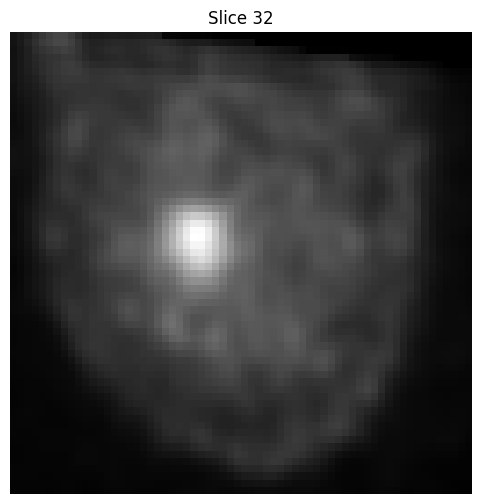

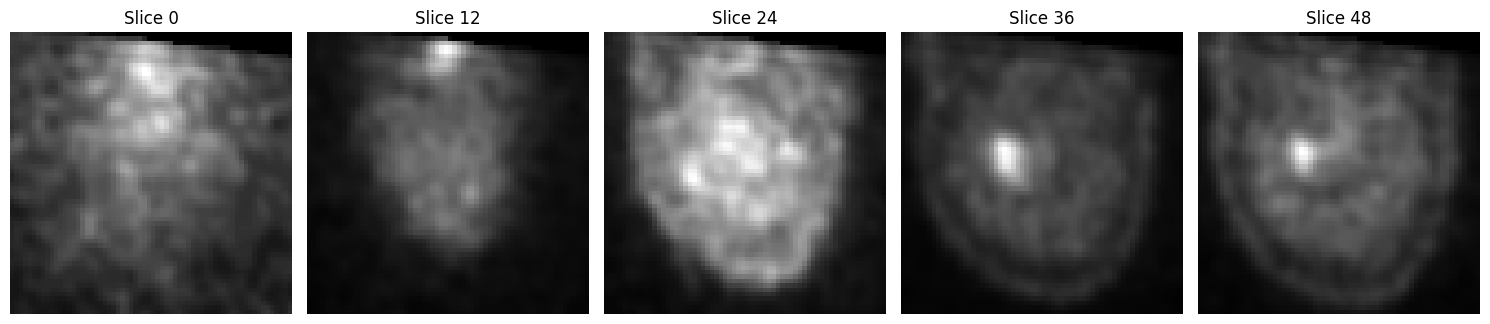

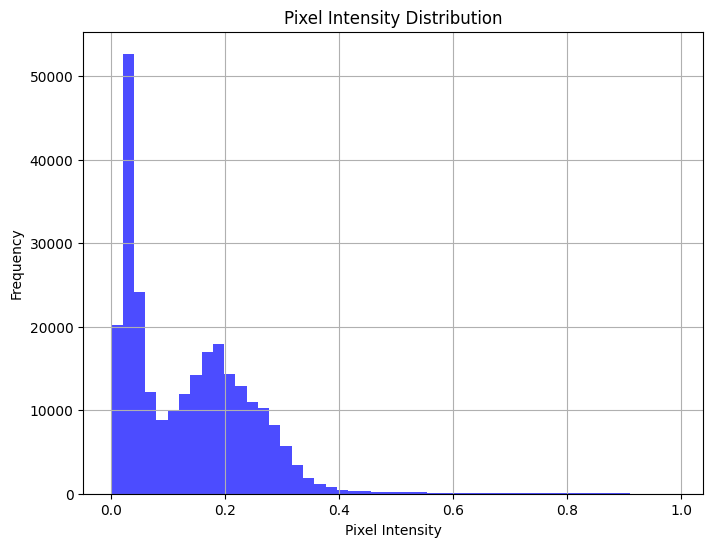

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Function to visualize a single slice from a DICOM volume
def visualize_slice(volume, slice_index):
    """
    Visualizes a single slice from a 3D DICOM volume.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(volume[:, :, slice_index], cmap='gray')
    plt.title(f"Slice {slice_index}")
    plt.axis('off')
    plt.show()

# Function to visualize multiple slices
def visualize_multiple_slices(volume, num_slices=5):
    """
    Visualizes multiple slices from a 3D DICOM volume.
    """
    depth = volume.shape[-1]
    step = depth // num_slices
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))
    for i in range(num_slices):
        slice_index = i * step
        axes[i].imshow(volume[:, :, slice_index], cmap='gray')
        axes[i].set_title(f"Slice {slice_index}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Function to create a 3D visualization of the volume
def visualize_3d(volume):
    """
    Creates a 3D visualization of the DICOM volume using Plotly.
    """
    fig = go.Figure(data=go.Volume(
        x=np.arange(volume.shape[0]),
        y=np.arange(volume.shape[1]),
        z=np.arange(volume.shape[2]),
        value=volume.flatten(),
        opacity=0.1,  # Adjust opacity for better visualization
        surface_count=20,  # Number of isosurfaces
        colorscale='Gray'
    ))
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ))
    fig.show()

# Function to create a histogram of pixel intensities
def plot_histogram(volume):
    """
    Plots a histogram of pixel intensities in the DICOM volume.
    """
    plt.figure(figsize=(8, 6))
    plt.hist(volume.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Example usage with a single patient volume
patient_id = '3871'  # Replace with a valid patient ID from preprocessed_volumes
if patient_id in preprocessed_volumes:
    volume = np.squeeze(preprocessed_volumes[patient_id])  # Remove singleton dimensions if present

    # Visualize a single slice
    visualize_slice(volume, slice_index=32)

    # Visualize multiple slices
    visualize_multiple_slices(volume, num_slices=5)

    # Create a 3D visualization
    visualize_3d(volume)

    # Plot a histogram of pixel intensities
    plot_histogram(volume)
else:
    print(f"Patient ID {patient_id} not found in preprocessed_volumes.")